## NYU PUI HOMEWORK 10 - Part 2 - Building Energy Efficiency

November 23, 2018

Author: zem232


### Code Reproducibility 

*The [following PEP8 rules](https://docs.google.com/document/d/1-XnKK4xRBA5FXOBa4p0Z4in7qfVyk4CutjSMEX-jpTQ/edit?usp=sharing) are now required*

-Data is downloaded in a reproducible way

-Captions adequately describe plot

-Axes clearly labeled 

-Comment on code

### Problem Statement

An interesting and popular urban science question is "can we measure and predict energy use based on observables that are easily acquired". For example the urban observatory at CUSP can monitor lights: they are a relatively easy observable. All you need is a camera, and a pipeline to process your data. But how does the light coming from a window relate to the total energy consumption? We generally postulate that light is a proxy for occupancy, and that occupancy is a good predictor of energy consumption.

So let's test if the last link holds. If we have data on the _energy consumed by a building_ how well does that relate to the _number of units_ in the building?

Data on energy consumption can be found here for the city of NY https://data.cityofnewyork.us/Environment/Energy-and-Water-Data-Disclosure-for-Local-Law-84-/rgfe-8y2z 

Either obtain the data through the API or download the csv file, and move it to $PUIDATA

However this datasets does not have the number of units. We can find that in the [Pluto dataset](https://www1.nyc.gov/site/planning/data-maps/open-data/dwn-pluto-mappluto.page).

** Reading in the Pluto data for manhattan, which will give me the number of units ber building   Manhattan/MNMapPLUTO.shp ** Note that you should keep all the files in the original MNMapPluto zipped folder (not just the .shp file) for geopandas to read the data in correctly.

# Data Acquisition

In [1]:
import pandas as pd
import numpy as np
import urllib.request
import os
import sys
import geopandas as gp
import pylab as pl
import matplotlib as plt
import optparse
import pysal
import statsmodels.formula.api as smf

%pylab inline

/Users/zoemartiniak/anaconda3/lib/python3.6/site-packages/pysal/__init__.py:65: VisibleDeprecationWarning: PySAL's API will be changed on 2018-12-31. The last release made with this API is version 1.14.4. A preview of the next API version is provided in the `pysal` 2.0 prelease candidate. The API changes and a guide on how to change imports is provided at https://pysal.org/about
  ), VisibleDeprecationWarning)


Populating the interactive namespace from numpy and matplotlib


/Users/zoemartiniak/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
# Removing the file from the diretory if they exist
# Otherwise errors can occur
! rm *Energy_and_Water_Data_Disclosure_for_Local_Law_84__2013*
! rm $PUIDATA/*Energy_and_Water_Data_Disclosure_for_Local_Law_84__2013*
url='https://data.cityofnewyork.us/api/views/rgfe-8y2z/rows.csv?accessType=DOWNLOAD'
urllib.request.urlretrieve(url,'Energy_and_Water_Data_Disclosure_for_Local_Law_84__2013_.csv')
! mv 'Energy_and_Water_Data_Disclosure_for_Local_Law_84__2013_.csv' $PUIDATA

rm: *Energy_and_Water_Data_Disclosure_for_Local_Law_84__2013*: No such file or directory


In [3]:
# Removing these files from directory first, otherwise error can occur
! rm *mn_mappluto_18v1*
! rm $PUIDATA/*mn_pluto*
! rm $PUIDATA/*MNMapPLUTO*
! rm $PUIDATA/*MN_Dcp*
! rm $PUIDATA/*PLUTODD18v1*
# downloading the PLUTO data for Manhattan
MHurl='https://www1.nyc.gov/assets/planning/download/zip/data-maps/open-data/mn_mappluto_18v1.zip'
urllib.request.urlretrieve(MHurl,'mn_mappluto_18v1.zip')
! unzip 'mn_mappluto_18v1.zip' -d $PUIDATA

Archive:  mn_mappluto_18v1.zip
  inflating: /Users/zoemartiniak/Documents/NYU/PUI/PUI2018/PUIdata/PLUTODD18v1.pdf  
  inflating: /Users/zoemartiniak/Documents/NYU/PUI/PUI2018/PUIdata/MN_Dcp_Mappinglot.dbf  
  inflating: /Users/zoemartiniak/Documents/NYU/PUI/PUI2018/PUIdata/MN_Dcp_Mappinglot.prj  
  inflating: /Users/zoemartiniak/Documents/NYU/PUI/PUI2018/PUIdata/MN_Dcp_Mappinglot.sbn  
  inflating: /Users/zoemartiniak/Documents/NYU/PUI/PUI2018/PUIdata/MN_Dcp_Mappinglot.sbx  
  inflating: /Users/zoemartiniak/Documents/NYU/PUI/PUI2018/PUIdata/MN_Dcp_Mappinglot.shp  
  inflating: /Users/zoemartiniak/Documents/NYU/PUI/PUI2018/PUIdata/MN_Dcp_Mappinglot.shp.xml  
  inflating: /Users/zoemartiniak/Documents/NYU/PUI/PUI2018/PUIdata/MN_Dcp_Mappinglot.shx  
  inflating: /Users/zoemartiniak/Documents/NYU/PUI/PUI2018/PUIdata/mn_pluto.dbf  
  inflating: /Users/zoemartiniak/Documents/NYU/PUI/PUI2018/PUIdata/mn_pluto.dbf.xml  
  inflating: /Users/zoemartiniak/Documents/NYU/PUI/PUI2018/PUIdata/MNMapPLU

In [4]:
# load the buildinmg size as a geoDF and the local law 84 as a dataframe
nrg = pd.read_csv(os.getenv("PUIDATA") + 
                  "/Energy_and_Water_Data_Disclosure_for_Local_Law_84__2013_.csv")

bsize = gp.GeoDataFrame.from_file(os.getenv("PUIDATA") + "/MNMapPLUTO.shp")

## Exploring the data a bit

As we discussed, coming up with a sensible model generally requires domain expertise. However, if the data you are investigating shows "obvious patterns", for example if two of the variable look like a line when plotted one against the other, then those patterns (correlations) may help you finding reasonable models for the data.

Explore your data, starting with a scatter matrix. 
A scatter matrix is a plot of all variables in your data against all other variables: 
each pair of variables is a subplot in the plot matrix. The diagonal line then would be a plot of a variable against itself, which is useless, so it is usually substituted by a histogram of that variable (or sometimes a KDE, which is basically a smooth histogram).

/Users/zoemartiniak/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: pandas.scatter_matrix is deprecated, use pandas.plotting.scatter_matrix instead
  """Entry point for launching an IPython kernel.


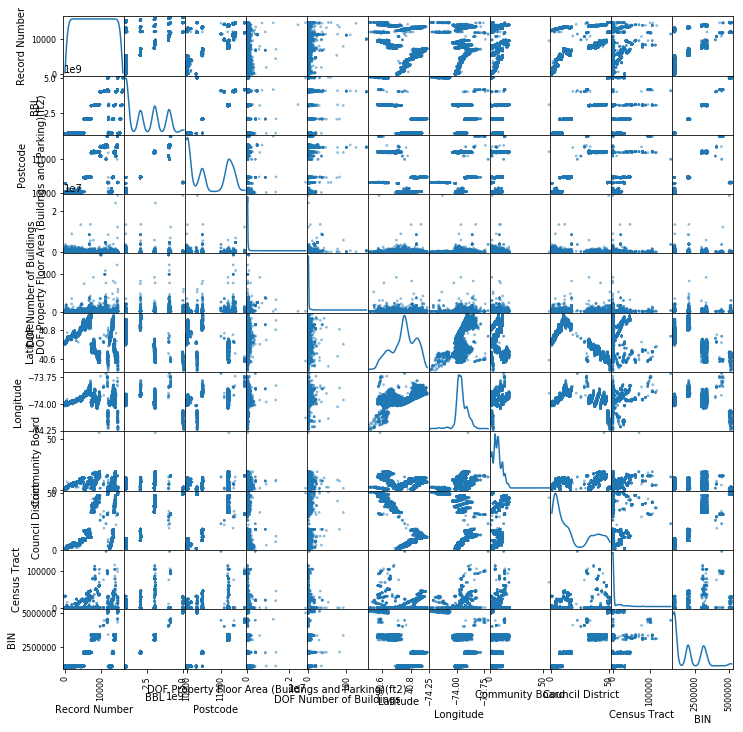

In [5]:
sfig = pd.scatter_matrix(nrg, s=30, figsize=(12, 12), diagonal='kde')

**Figure 1:** The above scatter matrix plot shows a scatterplot for each column pair in the Local Law 84 building energy dataset. The columns with plottable data in the raw dataset mostly consists of location specific and geographically descriptive information (e.g. the DOB BIN #, census tract) as well as the DOF building information (# of buildings, floor area), so this scatter matrix figure does not show anything particularly interesting, except that the buildings in Queens have much higher floor area (the BBL & BIN numbers are separated by borough).

### Dr. Bianco's Instructions:
This kind of plot shows correlations between variables, but it will also show me what can and cannot be plotted trivially in my dataset. Here only a few columns can be plotted: those that contain only numbers (and possibly NaN's), but most columns contain rows that cannot be converted to float (e.g. entries like 'See Primary BBL' in several rows for the energy dataframe 'Site EUI(kBtu/ft2) ' column) , so Pandas refuses to plot them, cause it does not know what to do with those entries. The columns I am interested in are in fact u'Site EUI(kBtu/ft2)' which is a measure of the energy consumed PER SQ FOOT by a building, and then the building area: for eg. u'Reported Property Floor Area (Building(s)) (ft²)'. Neither gets plotted: I need to remove all values that cannot convert to float in order to use the columns and convert them to float arrays and do math with them.

You can use pd.to_numeric() which is a function that transforms values to float (when possible). The default behavior of this function is to throw an error if it encounters a value that it cannot convert. That behavior can be modified with the "error" keyword, by setting it to "coerce". Please look at the function documentation to understand the syntax.

## Data cleaning and aggregation 

--> checking the content of the datasets


clean up columns I am not using: for my solution, I will keep  BBL, 'Site EUI(kBtu/ft2)', 'Reported Property Floor Area (Building(s)) (ft²)' from the energy dataframe, and BBL , UnitsTotal, UnitsRes, 'YearBuilt', and 'geometry' from the PLUTO geodaraframe

### remove what you do not need

In [6]:
nrg.columns

Index(['Record Number', 'BBL', 'Co-reported BBL Status', 'BBLs Co-reported',
       'Reported NYC Building Identificaiton Numbers (BINs)', 'Street Number',
       'Street Name', 'Borough', 'Postcode',
       'DOF Benchmarking Submission Status', 'Site EUI(kBtu/ft2)',
       'Weather Normalized Site EUI(kBtu/ft2)', 'Source EUI(kBtu/ft2)',
       'Weather Normalized Source EUI(kBtu/ft2)',
       'Municipally Supplied Potable Water - Indoor Intensity (gal/ft²)',
       'Automatic Water Benchmarking Eligible', 'Reported Water Method',
       'ENERGY STAR Score', 'Total GHG Emissions(MtCO2e)',
       'Direct GHG Emissions(MtCO2e)', 'Indirect GHG Emissions(MtCO2e)',
       'Reported Property Floor Area (Building(s)) (ft²)',
       'DOF Property Floor Area (Buildngs and Parking)(ft2)',
       'Primary Property Type - Self Selected', 'DOF Number of Buildings',
       'Latitude', 'Longitude', 'Community Board', 'Council District',
       'Census Tract', 'BIN', 'NTA'],
      dtype='object')

In [7]:
bsize.columns.sort_values()

Index(['APPBBL', 'APPDate', 'Address', 'AreaSource', 'AssessLand', 'AssessTot',
       'BBL', 'BldgArea', 'BldgClass', 'BldgDepth', 'BldgFront', 'Block',
       'BoroCode', 'Borough', 'BsmtCode', 'BuiltFAR', 'CB2010', 'CD', 'CT2010',
       'ComArea', 'CommFAR', 'CondoNo', 'Council', 'EDesigNum', 'Easements',
       'ExemptLand', 'ExemptTot', 'Ext', 'FIRM07_FLA', 'FacilFAR',
       'FactryArea', 'FireComp', 'GarageArea', 'HealthArea', 'HealthCent',
       'HistDist', 'IrrLotCode', 'LandUse', 'Landmark', 'Lot', 'LotArea',
       'LotDepth', 'LotFront', 'LotType', 'LtdHeight', 'MAPPLUTO_F',
       'NumBldgs', 'NumFloors', 'OfficeArea', 'OtherArea', 'Overlay1',
       'Overlay2', 'OwnerName', 'OwnerType', 'PFIRM15_FL', 'PLUTOMapID',
       'PolicePrct', 'ProxCode', 'ResArea', 'ResidFAR', 'RetailArea',
       'SHAPE_area', 'SHAPE_len', 'SPDist1', 'SPDist2', 'SPDist3', 'Sanborn',
       'SanitBoro', 'SanitDistr', 'SanitSub', 'SchoolDist', 'SplitZone',
       'StrgeArea', 'TaxMap', 'Tract201

In [8]:
## Creating a list of columns to drop except the columns of interest
dropcols=[i for i in nrg.columns.values if i != 'BBL' and 
          i != 'Site EUI(kBtu/ft2)' and 
          i !='Reported Property Floor Area (Building(s)) (ft²)']
nrg.drop(dropcols,axis=1,inplace=True)
nrg.head()

,BBL,Site EUI(kBtu/ft2),Reported Property Floor Area (Building(s)) (ft²)
0,1.000410e+09,NaN,918919
1,4.021460e+09,NaN,NaN
2,2.027620e+09,NaN,64200
3,1.006700e+09,NaN,NaN
4,2.048300e+09,NaN,50000


In [9]:
## Using same method for PLUTO
dropcols=[i for i in bsize.columns.values if i !='UnitsRes' and
         i !='UnitsTotal' and
         i !='YearBuilt' and
         i !='BBL' and
         i !='geometry']
bsize.drop(dropcols,axis=1,inplace=True)
bsize.head()

,UnitsRes,UnitsTotal,YearBuilt,BBL,geometry
0,16,18,1920,1.015450e+09,"POLYGON ((997277.2344360352 221816.0936279297,..."
1,50,50,1914,1.007238e+09,"POLYGON ((984164.5626220703 211846.0704345703,..."
2,10,10,1910,1.016800e+09,"POLYGON ((1000742.195800781 227910.6640014648,..."
3,29,32,1928,1.013850e+09,"POLYGON ((994007.6885986328 219880.4284057617,..."
4,26,26,1900,1.011970e+09,"POLYGON ((992273.6849975586 224863.4904174805,..."


/Users/zoemartiniak/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: pandas.scatter_matrix is deprecated, use pandas.plotting.scatter_matrix instead
  


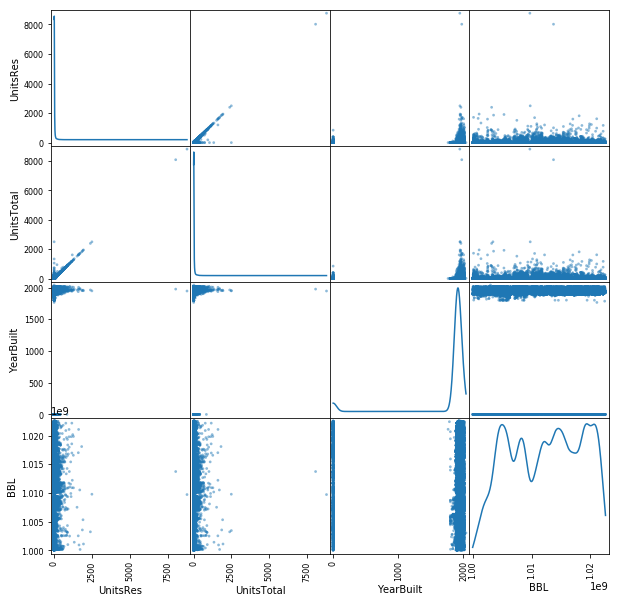

In [10]:
#leave (dont try this scatter matrix before cleaning the data, it will take a while)
sfig = pd.scatter_matrix(bsize, s=30, figsize=(10, 10), diagonal='kde')

**Figure 2:** Scatter matrix plot of the Manhattan PLUTO dataset. The plots shows that there are some erroneous entries -- for example, there are some buildings with a year built value of 0, which cannot be the case with this data. Factoring that into account, there seems to be a time period about 40 years ago when many buildings with high total and residential count. This time period corresponds to a surge of buildings built on the YearBuilt histogram plot. This may be attributed to erroneous entries as well, because 8000 residential units seems practically excessive for a single building. 

## converting  the relevant columns to numeric values and throwing away spurious entries

use pd.to_numeric() to convert strings to numeric values, remember the keyword "errors" which will be useful


In [11]:
## converting the column to numeric
## unfortunately pd.to_numeric does not allow inplace=True, so I have to redefine the column
## using errors='coerce' to set values to NaN for conversion errors that occur
nrg['Reported Property Floor Area (Building(s)) (ft²)']=pd.to_numeric(nrg['Reported Property Floor Area (Building(s)) (ft²)'],errors='coerce')

In [12]:
nrg['Site EUI(kBtu/ft2)']=pd.to_numeric(nrg['Site EUI(kBtu/ft2)'],errors='coerce')

In [13]:
## checking the conversion to float worked
print(nrg['Site EUI(kBtu/ft2)'].astype(float)[:10], '\n\n',
nrg['Reported Property Floor Area (Building(s)) (ft²)'].astype(float)[:10], '\n\n',
nrg.BBL.astype(float)[:10], '\n\n',
bsize.BBL.astype(float)[:10], '\n\n',
bsize.UnitsRes.astype(float)[:10], '\n\n',
bsize.UnitsTotal.astype(float)[:10], '\n\n',
bsize.YearBuilt.astype(float)[:10])


0   NaN
1   NaN
2   NaN
3   NaN
4   NaN
5   NaN
6   NaN
7   NaN
8   NaN
9   NaN
Name: Site EUI(kBtu/ft2), dtype: float64 

 0    918919.0
1         NaN
2     64200.0
3         NaN
4     50000.0
5     61800.0
6    102198.0
7     46620.0
8         NaN
9     54029.0
Name: Reported Property Floor Area (Building(s)) (ft²), dtype: float64 

 0    1.000410e+09
1    4.021460e+09
2    2.027620e+09
3    1.006700e+09
4    2.048300e+09
5    2.006120e+09
6    3.050770e+09
7    3.065710e+09
8    4.004490e+09
9    3.072240e+09
Name: BBL, dtype: float64 

 0    1.015450e+09
1    1.007238e+09
2    1.016800e+09
3    1.013850e+09
4    1.011970e+09
5    1.002360e+09
6    1.008370e+09
7    1.001960e+09
8    1.022240e+09
9    1.011270e+09
Name: BBL, dtype: float64 

 0    16.0
1    50.0
2    10.0
3    29.0
4    26.0
5     2.0
6     0.0
7     0.0
8    30.0
9    10.0
Name: UnitsRes, dtype: float64 

 0    18.0
1    50.0
2    10.0
3    32.0
4    26.0
5     3.0
6     8.0
7     2.0
8    30.0
9    10.0
Name: Unit

In [14]:
##check that your conversion worked: e.g.
print ("number of missing energy observations:", np.isnan(nrg['Site EUI(kBtu/ft2)'].astype(float)).sum())

number of missing energy observations: 4623


In [15]:
##check that your conversion worked: e.g.
print ("fraction of missing energy observations: %.2f"%(np.isnan(nrg['Site EUI(kBtu/ft2)'].astype(float)).sum() /
      len(nrg['Site EUI(kBtu/ft2)'])))

fraction of missing energy observations: 0.29


In [16]:
## Removing all values for Year Built = 0
bsize=bsize[bsize['YearBuilt'] >0]

 ## Merge the 2 datasets
 I can merge the dataframes on NYC Borough, Block, and Lot: BBL

In [17]:
#leave
#merge in a geodataframe for mapping, and if you want in a regular DF for analysis (more portable)
bblnrgdataGPD = bsize.merge(nrg,on='BBL')
bblnrgdata = nrg.merge(bsize,on='BBL')

In [18]:
# dropping geometry columns in regular DF & reformatting
bblnrgdata.drop('geometry',axis=1,inplace=True)
bblnrgdata.rename(columns={'Reported Property Floor Area (Building(s)) (ft²)':'Reported Property Floor Area'},inplace=True)
bblnrgdata.head()

,BBL,Site EUI(kBtu/ft2),Reported Property Floor Area,UnitsRes,UnitsTotal,YearBuilt
0,1.006700e+09,NaN,NaN,0,1,1987
1,1.004370e+09,NaN,NaN,0,4,1920
2,1.013110e+09,125.4,330000.0,0,56,1977
3,1.009220e+09,NaN,NaN,148,148,1963
4,1.007400e+09,NaN,68329.0,0,1,1920


In [19]:
bblnrgdataGPD.rename(columns={'Reported Property Floor Area (Building(s)) (ft²)':'Reported Property Floor Area'},inplace=True)

In [20]:
bblnrgdataGPD.dropna(axis=0,inplace=True)

# Plot the data as a choropleth for the 2 quantities of interest: number of units and energy consumed energy

In [21]:
## taking the log of floor area as well as building energy consumption.
## since some of these values are 0, and you cannot take log of 0, I added 0.001 to avoid this issue.
bblnrgdataGPD['logarea'] = log(bblnrgdataGPD['Reported Property Floor Area']+0.001)
bblnrgdataGPD['lognrg'] = log(bblnrgdataGPD['Site EUI(kBtu/ft2)']+0.001)

In [22]:
bblnrgdataGPD.describe()

,UnitsRes,UnitsTotal,YearBuilt,BBL,Site EUI(kBtu/ft2),Reported Property Floor Area,logarea,lognrg
count,5017.000000,5017.000000,5017.000000,5.017000e+03,5.017000e+03,5.017000e+03,5017.000000,5017.000000
mean,100.317919,113.056807,1943.540761,1.012023e+09,1.159821e+03,2.141611e+05,11.835615,4.405107
std,256.849497,259.643097,31.891456,5.511025e+06,4.297031e+04,3.243665e+05,0.828789,0.941921
min,0.000000,0.000000,1800.000000,1.000048e+09,0.000000e+00,2.700000e+03,7.901007,-6.907755
25%,0.000000,27.000000,1920.000000,1.008270e+09,6.590000e+01,7.211700e+04,11.186045,4.188154
50%,55.000000,64.000000,1930.000000,1.012370e+09,8.300000e+01,1.160210e+05,11.661526,4.418853
75%,114.000000,124.000000,1965.000000,1.015150e+09,1.040000e+02,2.204000e+05,12.303199,4.644401
max,8764.000000,8812.000000,2016.000000,1.022500e+09,3.018493e+06,9.515627e+06,16.068446,14.920268


Text(0.5,1,'Log Floor Area')

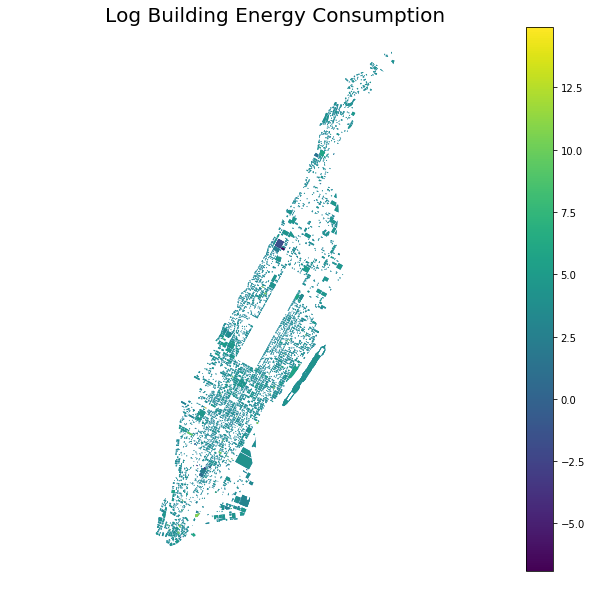

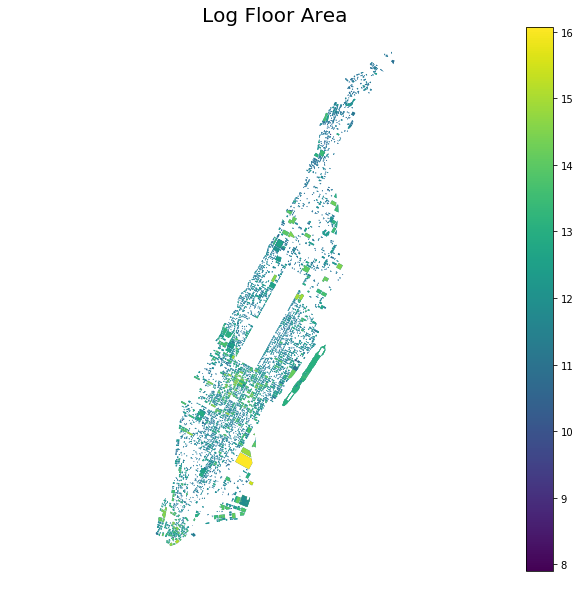

In [23]:
ax = bblnrgdataGPD.plot(figsize=(10,10))
xlim = ax.get_xlim()
ylim = ax.get_ylim()
ax = bblnrgdataGPD.plot(ax=ax,column='lognrg',cmap='viridis',alpha=1, linewidth=0.1, legend=True)
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_axis_off()
plt.axis('equal')
ax.set_title("Log Building Energy Consumption",size=20)

ax = bblnrgdataGPD.plot(figsize=(10,10))
xlim = ax.get_xlim()
ylim = ax.get_ylim()
ax = bblnrgdataGPD.plot(ax=ax,column='logarea',cmap='viridis',alpha=1, linewidth=0.1, legend=True)
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_axis_off()
plt.axis('equal')
ax.set_title("Log Floor Area",size=20)

**Figure 3:** The choropleths show the annual log energy consumption and log floor area for buildings in NYC in units of log(kBtu/ft2) and log(ft²), respectively. Since some of the values were 0 (but positive) I added 0.001 to each variable prior to taking the natural log to avoid errors. While it is difficult to spot the smaller lots on these plots, it is clear that the average log energy consumption is between 0 to 5 log(kBtu/ft2), and the average log floor area of buildings is between 11 and 15 log(ft2).

# feature engineering
the question was not if larger buildings consume more energy, its if occupancy increases consumption, so we want to model *total energy* with *total units*.
Create a total energy column from the columns you have.
Plot a column vs the other. You will be unable to see most of the points (as in the plot below). Make another plot "zooming in" to remove some outliers from the view and see if this reveals some patterns.

minimum building eneregy value 5344.0
maximum building eneregy value 9926784000.0


Text(0.5,1,'... & Zoomed In')

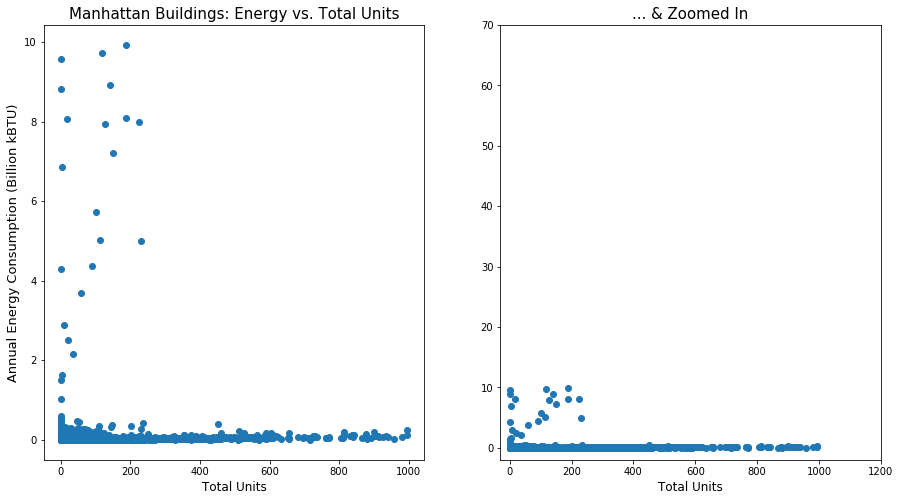

In [57]:
## multiplying area by energy/area to get total energy per building
bblnrgdata['nrg'] = bblnrgdata[\
    'Reported Property Floor Area'].astype(float) *\
                bblnrgdata['Site EUI(kBtu/ft2)'].astype(float)

print('minimum building eneregy value %.1f'%(bblnrgdata['nrg'].min()))
print('maximum building eneregy value %.1f'%(bblnrgdata['nrg'].max()))

## Plotting the columns vs the other: normal and zoomed in
x=bblnrgdata['UnitsTotal']
y=bblnrgdata['nrg']/1e9
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,8))
ax1.scatter(x, y)
ax1.set_title('Manhattan Buildings: Energy vs. Total Units',size=15)
ax1.set_ylabel('Annual Energy Consumption (Billion kBTU)',size=13)
ax1.set_xlabel('Total Units',size=12)
# setting the x & y extent limits to zoom in
ax2.set_xlim(-30,1200)
ax2.set_ylim(-2,70)
ax2.scatter(x, y)
ax2.set_xlabel('Total Units',size=12)
ax2.set_title('... & Zoomed In',size=15)

**Figure 4A, 4B:** Annual Energy consumption (Billion kBTU) is plotted against the total units for Manhattan buildings in Figure 4A (left), and zoomed in on Figure 4B (right). While many buildings report no energy consumption (regardless of unit size), there seems to be a correlation between the number of total units and annual energy consumption for Manhattan buildings. 

# The magic of log scales!
**Please read the following vcarefully! this is the only opportunity I have to discuss this with you this year. **

Very often in science we will visualize data in log scale and model log data instead of the natural dataset (generally in log10).

In in log10 every order of magnitude is separate by a unit: log10(10) = 1, log10(100) = 2, log10(100000)=5 (basically log10 gives you the number of 0's in its argument, or the *order of magnitude*)





/Users/zoemartiniak/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


Text(0,0.5,'$log_{10}$(x)')

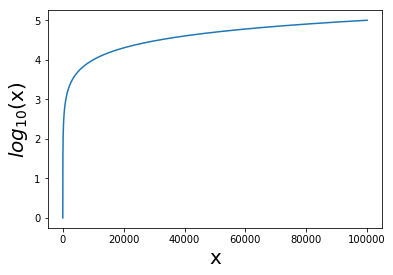

In [25]:
pl.plot(np.arange(100000), np.log10(np.arange(100000)), '-')
pl.xlabel("x", fontsize=20)
pl.ylabel(r"$log_{10}$(x)", fontsize=20)

The logarithm is a monotonic function : wherever its argument grows the function grows, wherever its argument decrease its log decrease. It's a function that grows fast when the argument is small and slowly when the argument is large, so it compresses the scale. 

Another property of the logarithm is that if the relationship between data is a power law (y = x^a) then the relationship between the log of the variables is linear! And we know that modeling things with linear models is easy!

	log_10(x^y) = y ∙ log_10(x)
    
And since power laws are very common in nature we often model with power laws, or with inear relationships in log space.

# Plot both NRG vs Units total and Units total vs NRG, both in log space

Surely there is a right way to think about which one is the independent and the dependent variable in this problem: do we think energy consumption causes occupancy or occupancy causes consumption?

You are going to have to limit the axis values or you will not see anything: 

    energy between (1000,1e10)

    units between (1,1000)

You can cut the axis to visualize the data like this, **but you will need to cut the data to remove datapoint outside of this range when you model to get a good model.**

to visualize the data in log scale you can use the dataframe plotting method with the argument 

    loglog=True


Text(0.5,1,'MH Bldgs: Total Units vs. Energy')

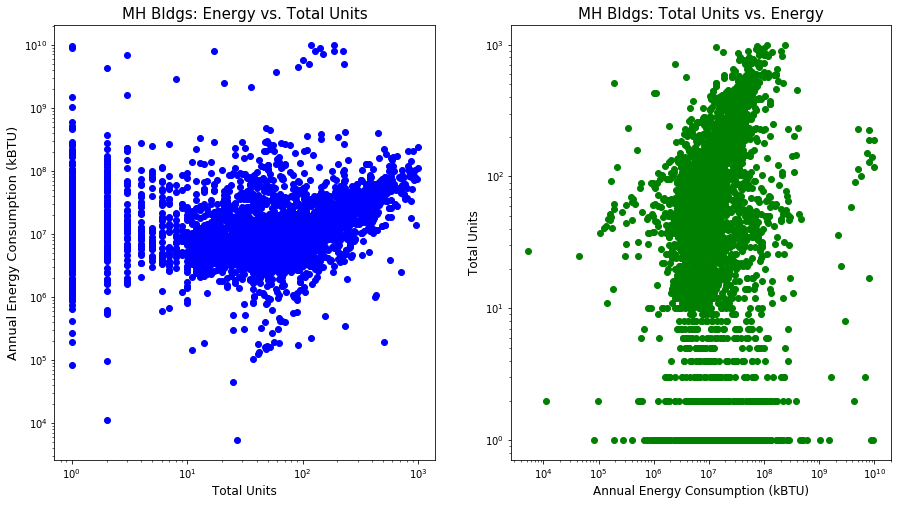

In [26]:
# removing the data outside of the limits
bblnrgdata=bblnrgdata[bblnrgdata['nrg'] > 1000] 
bblnrgdata=bblnrgdata[bblnrgdata['nrg'] < 1e10]
bblnrgdata=bblnrgdata[bblnrgdata['UnitsTotal'] >=1]
bblnrgdata=bblnrgdata[bblnrgdata['UnitsTotal'] <1000]
# setting x and y
x=bblnrgdata['UnitsTotal']
y=bblnrgdata['nrg']

## plotting the log-log plots next to each other
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,8))
ax1.loglog(x, y,'bo')
ax1.set_title('MH Bldgs: Energy vs. Total Units',size=15)
ax1.set_ylabel('Annual Energy Consumption (kBTU)',size=13)
ax1.set_xlabel('Total Units',size=12)
#ax1.set_xlim(-40,1000)
#ax1.set_ylim(1e5,1e10)

ax2.loglog(y, x,'go')
ax2.set_ylabel('Total Units',size=12)
ax2.set_xlabel('Annual Energy Consumption (kBTU)',size=12)
ax2.set_title('MH Bldgs: Total Units vs. Energy',size=15)
#ax2.set_ylim(-40,1000)
#ax2.set_xlim(1e5,1e10)

**Figure 5A (left):** The annual energy consumption in kBTU is plotted against total units for buildings in Manhattan, on a log-log scale (base 10). Considering causality, this plot it more consistent with the hypothesis that the total number of units within a building (independent) will determine its energy consumption (dependent). Looking at this plot, we see that there is a large centroid of datapoints with a common positive slope. 

**Figure 5AB(right):** The total building units is plotted against annual energy consumption for buildings in Manhattan on a log-log scale. This plot is not consistent with the hypothesis previously stated. It is not likely (or logical) that the annual energy consumption has a causal effect on the total units within a building. However, this plot does visually show a stronger correlation between the two variables. 

# Fit the data with a line in log space:  

**make sure you print the summary and plot the data and the model**

In [27]:
bblnrgdata['logunits']=log10(bblnrgdata['UnitsTotal'])
bblnrgdata['lognrg']=log10(bblnrgdata['nrg'])
OLSlog = smf.ols(formula='lognrg ~ logunits', data=bblnrgdata).fit()
OLSlog.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 lognrg   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     92.00
Date:                Tue, 27 Nov 2018   Prob (F-statistic):           1.34e-21
Time:                        01:45:26   Log-Likelihood:                -3281.9
No. Observations:                4923   AIC:                             6568.
Df Residuals:                    4921   BIC:                             6581.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      6.8754      0.018    374.896      0.000       6.839       6.911
logunits       0.0977      0.010      9.592      0.000       0.078       0.118
==============================================================================
Omnibus:                     1248.342   Durbin-Watson:                   1.604
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            10038.804
Skew:                           0.985   Prob(JB):                         0.00
Kurtosis:                       9.713   Cond. No.                         6.27
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

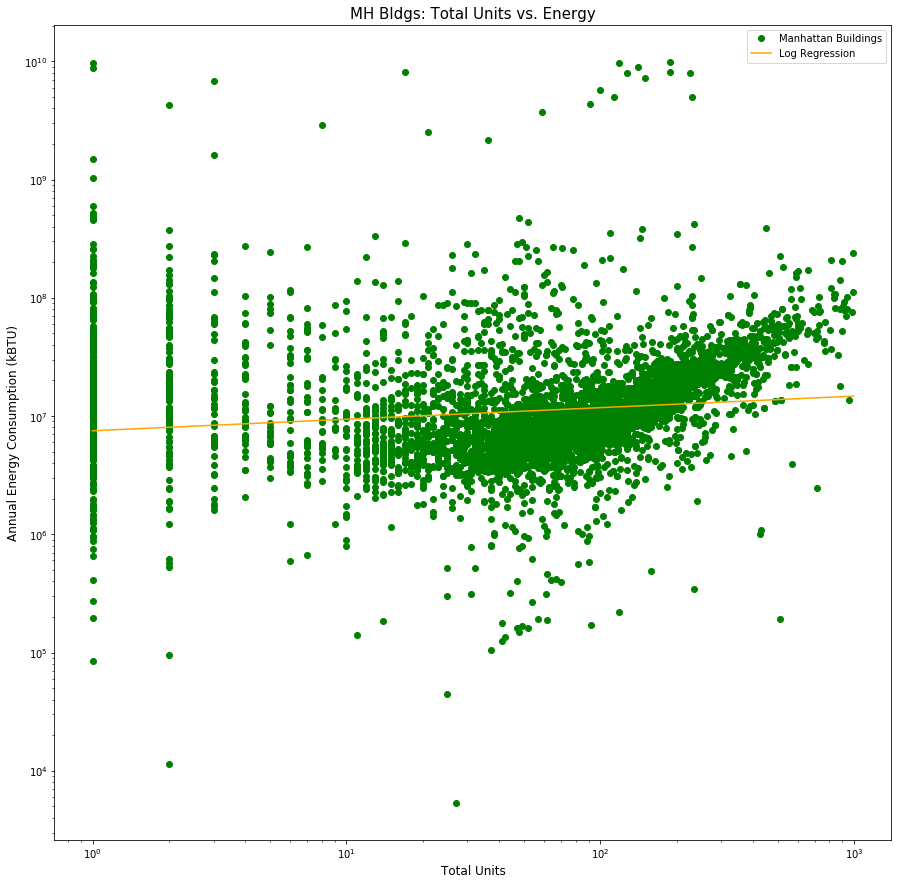

In [59]:
bblnrgdata.sort_values(['UnitsTotal'],inplace=True)
pl.figure(figsize=(15,15))
pl.loglog(bblnrgdata['UnitsTotal'], bblnrgdata['nrg'],'go',label='Manhattan Buildings')
pl.plot(bblnrgdata['UnitsTotal'], (bblnrgdata['UnitsTotal']**OLSlog.params[1])*10**OLSlog.params[0],\
        '-',color='orange',label='Log Regression')
pl.xlabel('Total Units',size=12)
pl.ylabel('Annual Energy Consumption (kBTU)',size=12)
pl.title('MH Bldgs: Total Units vs. Energy',size=15)
pl.legend()

**Figure 6:** The annual reported energy consumption (kBTU) for Manhattan buildings is plotted against total units on a log-log scale (base 10). A linear regression line fit using the log of the x and y variables is displayed. The linear regression does not exactly fit with the cluster of datapoints, however the line must be influenced by the large outliers present in this dataset. 

In [29]:
bblnrgdata['lnunits']=log(bblnrgdata['UnitsTotal'])
bblnrgdata['lnnrg']=log(bblnrgdata['nrg'])
OLSln = smf.ols(formula='lnnrg ~ lnunits', data=bblnrgdata).fit()
OLSln.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  lnnrg   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     92.00
Date:                Tue, 27 Nov 2018   Prob (F-statistic):           1.34e-21
Time:                        01:45:27   Log-Likelihood:                -7387.8
No. Observations:                4923   AIC:                         1.478e+04
Df Residuals:                    4921   BIC:                         1.479e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     15.8311      0.042    374.896      0.000      15.748      15.914
lnunits        0.0977      0.010      9.592      0.000       0.078       0.118
==============================================================================
Omnibus:                     1248.342   Durbin-Watson:                   1.595
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            10038.804
Skew:                           0.985   Prob(JB):                         0.00
Kurtosis:                       9.713   Cond. No.                         11.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

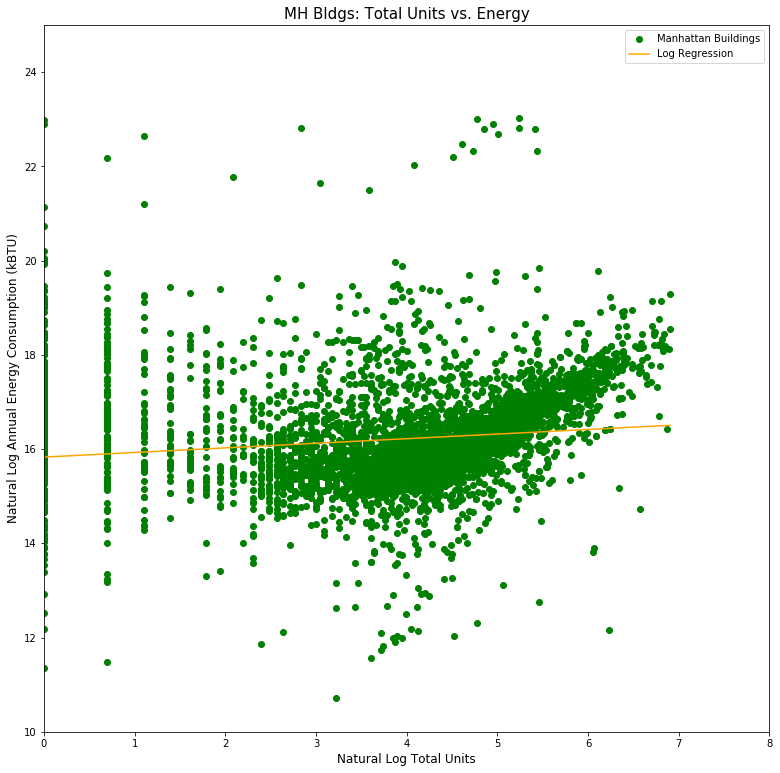

In [30]:
pl.figure(figsize=(13,13))
pl.plot(bblnrgdata['lnunits'], bblnrgdata['lnnrg'],'go',label='Manhattan Buildings')
pl.plot(bblnrgdata['lnunits'], OLSln.predict(bblnrgdata),\
        '-',color='orange',label='Log Regression')
pl.xlabel('Natural Log Total Units',size=12)
pl.ylabel('Natural Log Annual Energy Consumption (kBTU)',size=12)
pl.title('MH Bldgs: Total Units vs. Energy',size=15)
pl.xlim(0,8)
pl.ylim(10,25)
pl.legend()

**Figure 7:** The figure above shows the natural log of total annual energy consumption (kBTU) in Manhattan buildings plotted against the natural log of total building units. The linear regression line fit to the natural log of the x and y variables is shown, and seems to be influenced by the general positive correlation of the cluster of units and energy consumption on a natural log scale. However, the line has a much shallower slope than the cluster.

## Model NRG as a linear function of number of units in the building 
Ciertainly there is a right way to think about this: which is the *independent* and the *dependent* variable? which do we think causes which? do units "cause"energy consumption or vice versa? please answer below

**My answer:** It seems logical to assume that the number of units is independent and the building energy consumption is dependent. The total number of units in a building will influence its energy consumption, not the other way around. 

However, indulge me and try both models: models (nrg vs units total & units total vs nrg). 

- create the models with statsmodels
- print the model summary
- plot the data and the fit
- Check and comment on how the following model diagnostics change: 
        R^2 and LogLikelihood
        
(remember to use only the data in the appropriate range, see the previous step)

### Units vs Energy

In [31]:
bblnrgdata.head()

,BBL,Site EUI(kBtu/ft2),Reported Property Floor Area,UnitsRes,UnitsTotal,YearBuilt,nrg,logunits,lognrg,lnunits,lnnrg
1997,1.012220e+09,59863.9,160107.0,0,1,1969,9.584629e+09,0.0,9.981575,0.0,22.983427
4083,1.021390e+09,83.3,268859.0,0,1,1919,2.239595e+07,0.0,7.350170,0.0,16.924391
4079,1.021390e+09,568.1,324836.0,0,1,1975,1.845393e+08,0.0,8.266089,0.0,19.033373
4078,1.021390e+09,101.2,174347.0,0,1,1982,1.764392e+07,0.0,7.246595,0.0,16.685902
936,1.008090e+09,116.5,77761.0,0,1,1900,9.059156e+06,0.0,6.957088,0.0,16.019287


In [60]:
## cause is the total units as independent variable, and energy as dependent
OLScause = smf.ols(formula='lognrg ~ logunits', data=bblnrgdata).fit()
print(OLScause.summary())
## corr is the total units as the dependent variable
OLScorr = smf.ols(formula='logunits ~ lognrg', data=bblnrgdata).fit()
print('\n\n',OLScorr.summary())

                            OLS Regression Results                            
Dep. Variable:                 lognrg   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     92.00
Date:                Tue, 27 Nov 2018   Prob (F-statistic):           1.34e-21
Time:                        02:24:43   Log-Likelihood:                -3281.9
No. Observations:                4923   AIC:                             6568.
Df Residuals:                    4921   BIC:                             6581.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      6.8754      0.018    374.896      0.0

**Discussion:** While the r-squared is 0.018 for both the regressions, the likelihood is slightly less negative for the regression fit for the total units as the dependent variable.

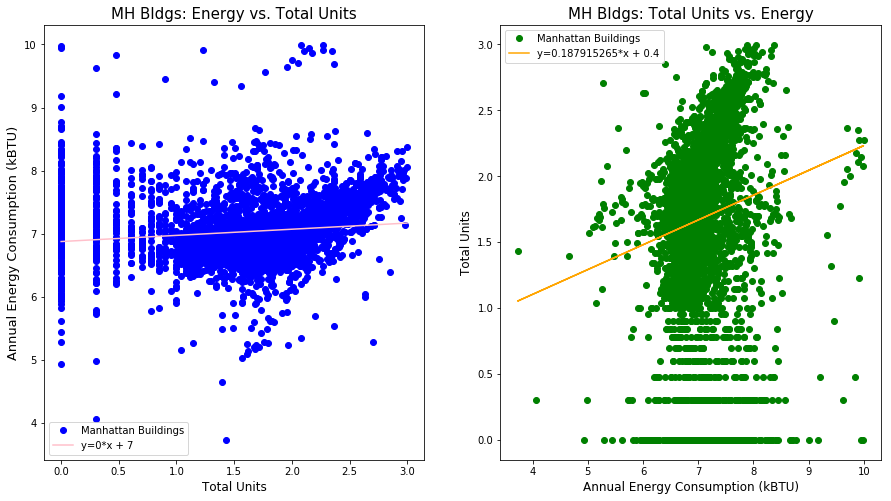

In [61]:
x=bblnrgdata['logunits']
y=bblnrgdata['lognrg']
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,8))
ax1.plot(x, y,'bo',label='Manhattan Buildings')
ax1.set_title('MH Bldgs: Energy vs. Total Units',size=15)
ax1.set_ylabel('Annual Energy Consumption (kBTU)',size=13)
ax1.set_xlabel('Total Units',size=12)
ax1.plot(x,OLScause.predict(x),'pink',label='y=%.f*x + %.f'%\
         (OLScause.params[1],OLScause.params[0]))
ax1.legend()

ax2.plot(y, x,'go',label='Manhattan Buildings')
ax2.set_ylabel('Total Units',size=12)
ax2.set_xlabel('Annual Energy Consumption (kBTU)',size=12)
ax2.set_title('MH Bldgs: Total Units vs. Energy',size=15)
ax2.plot(y,OLScorr.predict(y),'orange',label='y=%.9f*x + %.1f'%\
         (OLScorr.params[1],OLScorr.params[0]))
ax2.legend()

**Figure 8A (left):** The annual energy consumption in kBTU is plotted against total units for buildings in Manhattan and fitted with a linear regression line. Considering causality, this plot illustrates the hypothesis that the total number of units within a building (independent) will determine its energy consumption (dependent). The log-linear regression seems to describe the cluster better than the linear regression in Figure 8B.

**Figure 8B (right):** The total units is plotted against annual energy consumption in kBTU for buildings in Manhattan, and fitted with a regression line. This plot shows the hypothesis that the annual energy consumption (independent) will determine the total units (dependent). The linear regression better describes the increase in annual energy consumption with a limited range for total building units. 

# Second degree polynomial fit

model the data with a slightly more complex model: 
    
    y = ax*x + bx + c, 

instead of 
        
    y = bx + c
    
**make sure you print the summary and plot the data and the model**


In [65]:
bblnrgdata.drop(['lnunits','lnnrg'],axis=1,inplace=True)

In [67]:
bblnrgdata['logunits2']=bblnrgdata['logunits']**2
OLSx2 = smf.ols(formula='lognrg ~ logunits + logunits2', data=bblnrgdata).fit()
print(OLSx2.summary())

                            OLS Regression Results                            
Dep. Variable:                 lognrg   R-squared:                       0.158
Model:                            OLS   Adj. R-squared:                  0.157
Method:                 Least Squares   F-statistic:                     460.7
Date:                Tue, 27 Nov 2018   Prob (F-statistic):          4.10e-184
Time:                        02:31:05   Log-Likelihood:                -2905.0
No. Observations:                4923   AIC:                             5816.
Df Residuals:                    4920   BIC:                             5835.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.2568      0.022    335.692      0.0

**Discussion:** The R-squared is much larger at 0.158 and the log likelihood has increased slightly, therefore this quadratic equation is a better fit for the data.

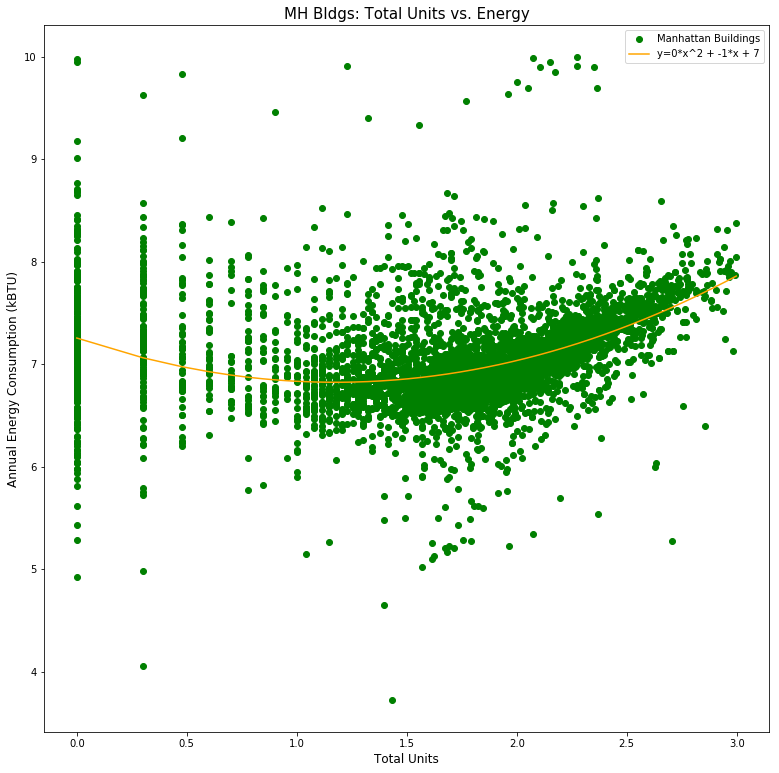

In [68]:
pl.figure(figsize=(13,13))
pl.plot(bblnrgdata['logunits'], bblnrgdata['lognrg'],'go',label='Manhattan Buildings')
pl.plot(bblnrgdata['logunits'], OLSx2.predict(bblnrgdata),\
        '-',color='orange',label='y=%.f*x^2 + %.f*x + %.f'%\
         (OLSx2.params[2],OLSx2.params[1],OLSx2.params[0]))
pl.xlabel('Total Units',size=12)
pl.ylabel('Annual Energy Consumption (kBTU)',size=12)
pl.title('MH Bldgs: Total Units vs. Energy',size=15)
pl.legend()

**Figure 9:** The annual building energy consumption plotted against the total building units for Manhattan buildings, fitted with a quadratic regression line. As discussed above, the r-squared has increased and the likelihood has also slightly increased, meaning that the regression fit is more likely to describe the data.

# calculate the chi square and likelihood of your model

## Define a chisquare function

In [69]:
#leave
def chi2(data, model, errors = None):
    '''Calculates the chi sq given data, model and errors
    Arguments:
    data: series of datapoints (endogenous variable)
    model: series of predicted values corresponding to the observed data
    errors: series of errors (optional). 
    If errors are not passes all errors are set to 1
    '''
    if errors == None:
        errors=1
    values = np.array(data)
    E = np.array(model)
    return (((values - E) / errors)**2).sum()

In [76]:
data, model1 = bblnrgdata['UnitsTotal'], OLSx2.predict(bblnrgdata)
chi2(data,model1)

119574130.50759524

## Define and calculate errors

Assume Poisson statistics and calculate the errors accordingly. Remember that you have used 2 quantities combined linearly to calculate the energy (your *dependent* variable) , so the errors combine in quadrature!

    Total Error = sqrt(error1^2 + error2^2)
    
Your *independent* variable has uncertainty also! assume it is also Poissonian

** propagation of errors on the log:**
https://en.wikipedia.org/wiki/Propagation_of_uncertainty#Linear_combinations

$f=a\log _{10}(A)$

$\sigma _{f}\approx \left(a{\frac {\sigma _{A}}{A\ln(10)}}\right)$

In [36]:
## Assume that there is error in the reported energy. 
## but that is the product of two measured qusntities, each of which will have errors. 
## The minimum error is the squareroot of the value

#errors on the measured quantities
bblnrgdataCut['errorsnrg'] = ...

# better WOULD BE to calculate each error and add in quadrature: sqrt(1/A + 1/B) which becomes
#errorsnrg = np.sqrt(1.0 / bblnrgdataCut['Reported Property Floor Area'] + 1.0 / bblnrgdataCut['Site EUI(kBtu/ft2)'])
#but this leads to insane error values (insanely small)

## Assume count statistics in the number of units as well
bblnrgdataCut['errorsunits'] = ...


NameError: name 'bblnrgdataCut' is not defined

## Make 3 plots: one with x errors, one with y errors, one with x and y errors. 

with pylab you can do it with pl.errorbar(x, y, xerr=xerror, yerr=yerror)

In [ ]:
#I could also include errors for number of units
fig2 = plt.figure(constrained_layout=True, figsize=(15,15))

gs1 = gridspec.GridSpec(3, 3, figure=fig2)
gs1.update(left=0.68, right=0.68, wspace=0.2)


ax1 = plt.subplot2grid((3, 3), (0, 0), colspan=1)
ax1.errorbar(np.log10(bblnrgdataCut.nrg), np.log10(bblnrgdataCut.UnitsTotal), 
            yerr=bblnrgdataCut.errorsunits, fmt='.',
            alpha=0.5)
ax1.set_ylabel("log10 of Units", fontsize=15)
ax1.set_xlabel("log10 Energy", fontsize=15)
pl.suptitle("Total units in building as function of Energy")


ax2 = plt.subplot2grid((3, 3), (0, 1), colspan=1)
ax2.errorbar(np.log10(bblnrgdataCut.UnitsTotal), np.log10(bblnrgdataCut.nrg), 
            yerr=bblnrgdataCut.errorsnrg, fmt='.',
            alpha=0.5)
ax2.set_xlabel("log10 of Units", fontsize=15)
ax2.set_ylabel("log10 Energy", fontsize=15)

ax4 = plt.subplot2grid((3, 3), (1, 0), colspan=2, rowspan=2)
ax4.errorbar(np.log10(bblnrgdataCut.UnitsTotal), np.log10(bblnrgdataCut.nrg), 
            yerr=bblnrgdataCut.errorsnrg,
           xerr=bblnrgdataCut.errorsunits, alpha=0.5, fmt='.')
ax4.set_xlabel("log10 of Units", fontsize=15)
ax4.set_ylabel("log10 Energy", fontsize=15)
ax4.set_ylim(5,11)

print ("The largest error bar is for")
bblnrgdataCut[bblnrgdataCut.errorsnrg == bblnrgdataCut.errorsnrg.max()]


Figure 7: The same as Figure 5 and 6, but with errorbars. In the top panel the errors on the Units in the building are plotted, in the bottom panels the errors on the energy are plotted, but they are too small to see,  and both on the right side panel. The bottom right panel is a zoom-in of the bottom left panel. Errors are measured by assuming Poisson statistics at the measurement level for energy per square foot, squarefootage, and for the number of units, and propagate properly to the log space. Notice that we do not know what the units of energy really represent: the Poisson statitics should be applied to the measured counts, but the enrgy consumption is a continuous variable, only discretized by the act of measuring it. 

IMPORTANT! errors as the square root of the measurement (Poisson statistics) are ONLY meaningful when you are potting dimensionless quantoities! here it is preposterous to assume that the errors are the square root of the measurement. WHY? because then if I express my energy by sq meter, instead of sq feet, I get a different error on the measurement for the same measurement - which makes no sense! However, in this case, I am not using the errors to create the model (no WLS for example) so this error allows me to compare uncertainty on the datapoints. Even if the errors are different, under linear transformations (changes of units for example) the relationship between errors on 2 datapoints will be preserved. 

Notice: No points are taken off if other errors are used, including the sqrt of the log energy, and the correct errors propagation in the log on errors calculated, however, as the sqrt of the tot energy per building, but the errors are in the measured quantities, so this is the proper way to obtain them. In addition the units of energy are extremely large, thus the errors in percentage on the energy are extremely small. These errors are likely to be underestmated due to our ignorance of the details of the experiment.

## Add the errors and calculate the chi square


### calculate the degrees of freedom of this model

In [ ]:
#degrees of freedom: number of observations - number of model parameters
# note: these are reported as dof of the residuals in the statsmodels fit summary, but jsut to make sure let's calculate them
dof = ...
print ("degrees of freedom:" , dof)

In [ ]:
print ("Units vs Energy residuals (no errors include): %.2f"%\
       (chi2(np.log10(bblnrgdataCut.UnitsTotal), linmodel_0.predict()) / 
        float(dof)))

print ("Units vs Energy chi square per DOF w independent variable error only: %.2f"%\
       (chi2(np.log10(bblnrgdataCut.UnitsTotal), linmodel_0.predict(), 
            errors = bblnrgdataCut.errorsnrg) / dof))

print ("Units vs Energy chi square per DOF : %.2f"%\
       (chi2(np.log10(bblnrgdataCut.UnitsTotal), linmodel_0.predict(), 
            errors = np.sqrt(bblnrgdataCut.errorsnrg**2 + 
                             bblnrgdataCut.errorsunits**2))  / dof))


In [ ]:
print ("Energy vs Units residuals (no errors include): %.2f"%\
       (chi2(np.log10(bblnrgdataCut.nrg), linmodel_1.predict()) / dof))

print ("Energy vs Units chi square per DOF w independent variable error only: %.2f"%\
       (chi2(np.log10(bblnrgdataCut.nrg), linmodel_1.predict(), 
            errors = bblnrgdataCut.errorsnrg) / dof))

print ("Energy vs Units chi square per DOF : %.2f"%\
       (chi2(np.log10(bblnrgdataCut.nrg), linmodel_1.predict(), 
            errors = np.sqrt(bblnrgdataCut.errorsnrg**2 + 
                             bblnrgdataCut.errorsunits**2))  / dof))


### Compare the models using the  chi square:
discuss

If the result of the units vs energy surprises you plot the influence plot for the model. Except the default statsmodels influence plot is a bit of a mess, cause so many points have high leverage, and thus high influence, that the labels cover the span of the plot and make it useless. One could relatively easily engineered one's own influence plot, but instead for the purpose of this discussion comparing the units vs energy with the energy vs units influence plot is sufficient to show how many more points with high **leverage** are in the first plot than in the second - look at the axis range! What is happening is that the distribution of points along the exogenous variable is much better suited to a line fit in the energy vs units plot. You want a large spread in the exogenous variable. In the units vs energy most values of the exogenous variable (energy in this case) are clustered in a small range, while the endogenous variable varies greatly for those points. So the core of the distribution has low predictive power, and the importance of the "outliers" with high and low energy values is enhanced in the fit. 

Figure 10: ...

# Comparing the linear and curve fit with Likelihood Ratio LR test; we require a significance $\alpha=0.05$

** The curve fit and linear fit od the Energy vs Units can be compared with LR test because they are nested models**

** The difference in the number of degrees of freedom is 1, so the LR statistics will follow a $\chi^2$ distribution with 1 DOF.**


LR = ...
**reject / not reject...**

## EC 1 Plotting the likelihood surface (assuming gaussian statistics)

when you assume Gaussian statistics the log likelihood is the chi square, so you can plot the chi square from the function you created earlier!

* choose a reasonable range of a, b, and c for your parameters. 
* calculate the chisquare for each value in the range: this can be done in a nested for loop
* save the value of the chi square and plot it as a surface

in pylab you can plot surfaces with pl.imshow()


### creating a function that returns the likelihood value on a grid
We already have the function! If we assume a Gaussian distribution then the likelihood is the chi square (not exactly, but it is a linear function of the chi squared, which means that maximizing the log likelihood is the same as minimizing the chi square).
this is a brute force minimization, which is escruciatingly slow and should not be done due to its inefficiency, but it is a transparent code that allows you to see what it means to maximize the likelihood surface (which is equivalent to minimizing the sum of the residuals squared, or the chi squared if errors are used)

### calculating and plotting the loglikelihood in a 2D sensible range of values
plot is for 
    - chi square calculated with no errors (i.e. sum of residuals squared)
    - chi squared with errors
    
compare the surfaces

In [ ]:
fig = pl.figure(figsize=(20,10))
ax1 = fig.add_subplot(121)
ax1.set_title ("log likelihood surface, no errors", fontsize = 22)
pl.imshow(np.log(resids_noerror), extent = [-50,50,100,-100], aspect=0.5)
ax1.set_xlabel('slope', fontsize = 22)
ax1.set_ylabel('intercept', fontsize = 22)
pl.colorbar()

ax2 = fig.add_subplot(122)
ax2.set_title ("log likelihood surface", fontsize = 22)
pl.imshow(np.log(resids), extent = [-50,50,100,-100], aspect=0.5)
ax2.set_xlabel('slope', fontsize = 22)
ax2.set_ylabel('intercept', fontsize = 22)
pl.colorbar();


Figure 11: ...

In [ ]:
#leave
#plotting the difference between the 2 likelihood surfaces to see if the minimum is in the right place
ax1 = pl.figure(figsize=(10,10)).add_subplot(111)
ax1.set_title ("log likelihood surface difference \n between model with and without errors", fontsize = 22)
pl.imshow(np.abs(np.log(resids) - np.log(resids_noerror)), extent = [-50,50,100,-100], aspect=0.5, cmap='bone')
ax1.set_xlabel('slope', fontsize = 22)
ax1.set_ylabel('intercept', fontsize = 22)
pl.colorbar();


Figure 12: ...

# EXTRA CREDIT: a plot of anything related to these data

In [ ]:
ax = pl.figure(figsize=(10,10)).add_subplot(111)
bblnrgdataCut['YearBuilt'][bblnrgdataCut['YearBuilt']<1800]=1800

bblnrgdataCut.plot(kind='scatter', x='nrg', y='UnitsTotal', 
                fontsize=22, colormap='gist_earth', alpha = 0.5, 
                marker='o',  figsize=(16, 14), loglog=True,  
                xlim=(1000,1e11), ylim=(1,1000), ax = ax,
                c= dt.datetime.today().year - bblnrgdataCut['YearBuilt'], 
                s=bblnrgdataCut['UnitsTotal']/bblnrgdataCut['UnitsRes'] * 100)
pl.title('Units vs Energy consumption (log-log plot)\nColor maps Age in years, Size maps total/residential units', 
         fontsize=18)
pl.ylabel("total number of units", fontsize=22)
pl.xlabel("total energy consumption (kBtu)", fontsize=22);


Figure 13: Plot of Number of Units as a function of energy consumption for all NYC buildings with self reported energy consumption in the Local Law 84 database. The color of each datapoint representes the age: darker colors are buildings of more recent construction. The size of the mark represents the inverse of the fraction of residential units in the building (large datapoints indicate a small fraction of residential units, i.e. a comercial building). 

There is a weak color gradient where younger buildings dominate the higher portion of the plot. This could be interpreted as higher efficiency: at the same energy consumption younger buildings host more people. Or it could be driven by architectural changes: a trend to host the same number of people segregating them in more smaller units.

Aside from a few obvious outliers there is no obvious trend in fraction of residential units with building age, energy, or total number of units